In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

create variables for image size and batch size


In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

load data into variable dataset

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(

    "PotatoData",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
    
    
)

Found 5780 files belonging to 13 classes.


Display class names(different plant and disease list)

In [4]:
class_names = dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


length of dataset(which is 1 batch is of 32 images)

In [5]:
len(dataset)

181

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)

(32, 256, 256, 3)


Visualize a some images

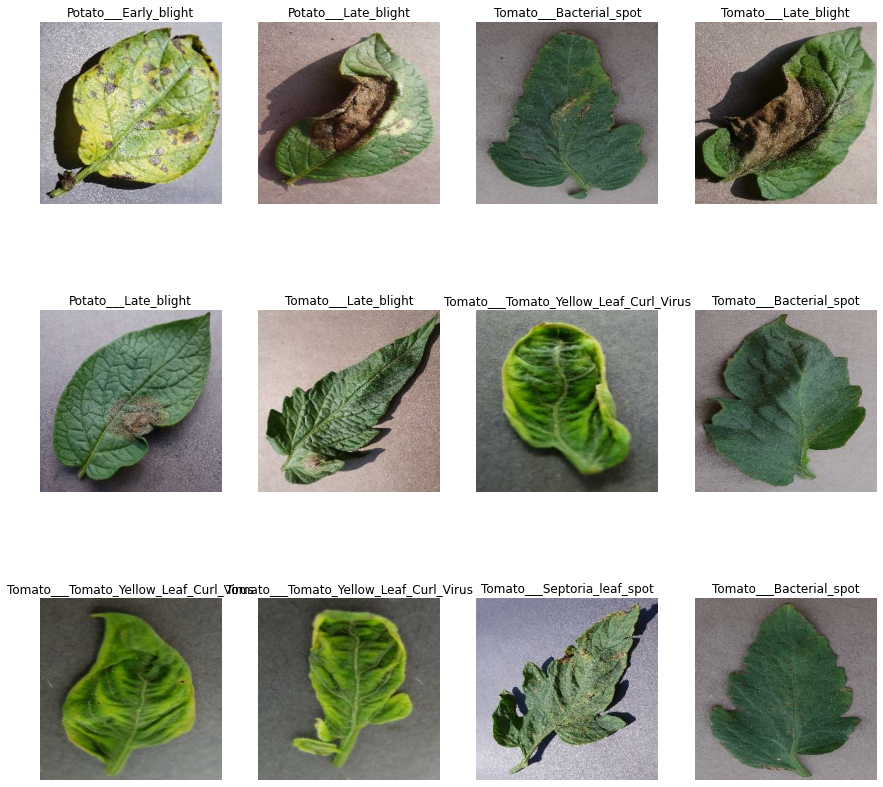

In [7]:
plt.figure(figsize = (15,15))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [8]:
train_size = 0.8
len(dataset)*train_size

144.8

In [9]:
train_ds = dataset.take(144)
len(train_ds)

144

In [10]:
test_ds = dataset.skip(144)
len(test_ds)

37

In [11]:
val_size = 0.1
len(dataset)*0.1

18.1

In [12]:
val_ds = test_ds.take(18)

In [13]:
test_ds = test_ds.skip(18)

Write a function for train test split
80% for training 10% for validation and 10% for testing

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

call train test split function

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

144

In [17]:
len(val_ds)

18

In [18]:
len(test_ds)

19

Optimize training performance with prefetch

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Preprocessing of image(resize and rescale)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

Data Augmentation (apply randomflip and rotation)

In [22]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

Building model

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 13
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')   
    
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (32, 60, 60, 128)        

compile model

In [26]:
model.compile(
optimizer = 'adam',
loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
metrics=['accuracy'])

training of model

In [27]:
history = model.fit(
train_ds,
epochs=30,
batch_size=BATCH_SIZE,
verbose=1,
validation_data=val_ds
)

Epoch 1/30
144/144 [==============================] - 836s 5s/step - loss: 1.9422 - accuracy: 0.3533 - val_loss: 1.5640 - val_accuracy: 0.4983
Epoch 2/30
144/144 [==============================] - 471s 3s/step - loss: 1.3812 - accuracy: 0.5467 - val_loss: 1.4646 - val_accuracy: 0.5312
Epoch 3/30
144/144 [==============================] - 580s 4s/step - loss: 1.1000 - accuracy: 0.6432 - val_loss: 1.3999 - val_accuracy: 0.5156
Epoch 4/30
144/144 [==============================] - 540s 4s/step - loss: 0.9633 - accuracy: 0.6912 - val_loss: 0.8444 - val_accuracy: 0.6944
Epoch 5/30
144/144 [==============================] - 497s 3s/step - loss: 0.8352 - accuracy: 0.7224 - val_loss: 1.1183 - val_accuracy: 0.6476
Epoch 6/30
144/144 [==============================] - 501s 3s/step - loss: 0.7650 - accuracy: 0.7472 - val_loss: 0.8136 - val_accuracy: 0.7049
Epoch 7/30
144/144 [==============================] - 544s 4s/step - loss: 0.6531 - accuracy: 0.7860 - val_loss: 0.5839 - val_accuracy: 0.7726

evaluation of model

In [28]:
scores = model.evaluate(test_ds)

19/19 [==============================] - 129s 925ms/step - loss: 0.2519 - accuracy: 0.9161


check validation accuracy and validation loss

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

drawing a validation accuracy and validation loss graph

Text(0.5, 1.0, 'Training and Validation Loss')

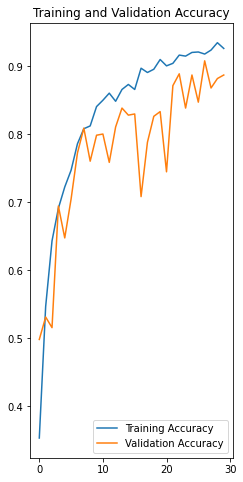

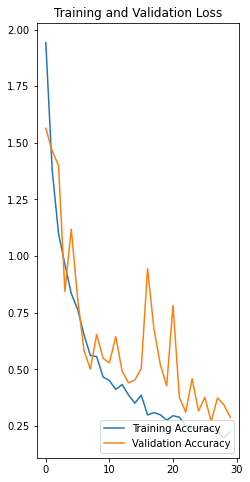

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(30), acc, label='Training Accuracy')
plt.plot(range(30), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(30), loss, label='Training Accuracy')
plt.plot(range(30), val_loss, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

compare actual and predicted class of image

first image to predict
actual label:  Tomato___Target_Spot
predicted label:  Tomato___Target_Spot


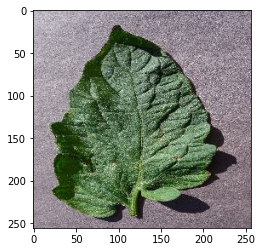

In [36]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [37]:
def predict(model,img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])), 2)
    return predicted_class, confidence

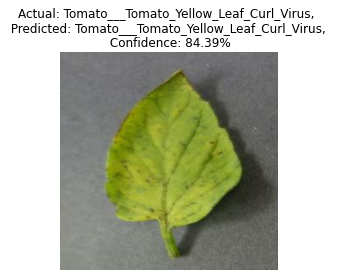

In [38]:
for images, labels in test_ds.take(1):
    for i in range(9):
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        
        plt.axis("off")
        

In [39]:
model_version = "tomato_potato2"
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/tomato_potato2\assets


In [40]:
model.save("../plant_detect.h5")
